In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import *
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [2]:
def drop_useless_features(data_frame):
    return data_frame.drop(columns=["EmployeeCount", "StandardHours", "Over18", "id"])

def drop_correlated_features(data_frame):
    return data_frame.drop(columns=["JobLevel", "PerformanceRating", "YearsWithCurrManager"])

def fill_outliers(data_frame):
    for name in data_frame:
        if name != 'id' and data_frame[name].dtype == int:
            col = data_frame[name]
            data_frame.loc[data_frame[name] > col.quantile(0.99), name] = col.quantile(0.99)

            col = data_frame[name]
            data_frame.loc[data_frame[name] < col.quantile(0.01), name] = col.quantile(0.01)
    return data_frame

def preprocess_data(data):
    d1 = drop_useless_features(data)
    # d1 = drop_correlated_features(d1)
    d1 = fill_outliers(d1)
    return d1

def cross_validate(X, y, model):
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1337)
    all_scores = []

    for fold_id, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_tr, y_tr)

        y_pred = model.predict_proba(X_val)[:, 1]

        auc = roc_auc_score(y_val, y_pred)

        print(f"Fold {fold_id} \t auc: {auc}")

        all_scores.append(auc)

    avg_auc = np.mean(all_scores)

    print(f"Avg AUC: {avg_auc}")


In [3]:
data_raw = pd.read_csv('playground-series-s3e3/train.csv', low_memory=False)
X_test_raw = pd.read_csv('playground-series-s3e3/test.csv', low_memory=False)

X_train_raw = data_raw.drop(columns='Attrition')
y_train = data_raw['Attrition']
X_train = preprocess_data(X_train_raw)
X_test = preprocess_data(X_test_raw)

/var/folders/l_/xql371mn41x5cxzwk9st0bfr0000gn/T/ipykernel_30612/268290183.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '19550.04' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_frame.loc[data_frame[name] > col.quantile(0.99), name] = col.quantile(0.99)
/var/folders/l_/xql371mn41x5cxzwk9st0bfr0000gn/T/ipykernel_30612/268290183.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '26718.36' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_frame.loc[data_frame[name] > col.quantile(0.99), name] = col.quantile(0.99)
/var/folders/l_/xql371mn41x5cxzwk9st0bfr0000gn/T/ipykernel_30612/268290183.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '18.18' 

In [4]:
cat_features = [col for col in X_train.columns if 20 >= X_train[col].nunique() > 1]
cont_features = [col for col in X_train.columns if X_train[col].nunique() > 20]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), cont_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)

In [5]:
base_pipeline = Pipeline([
    ("transform", preprocessor),
    ('random_forest', CatBoostClassifier(verbose=False))
])

cross_validate(X_train, y_train, base_pipeline)

Fold 0 	 auc: 0.7733108108108109
Fold 1 	 auc: 0.8135135135135135
Fold 2 	 auc: 0.8513513513513513
Fold 3 	 auc: 0.897972972972973
Fold 4 	 auc: 0.8334459459459459
Fold 5 	 auc: 0.7320945945945945
Fold 6 	 auc: 0.8040540540540541
Fold 7 	 auc: 0.8448979591836735
Fold 8 	 auc: 0.8659863945578231
Fold 9 	 auc: 0.860204081632653
Avg AUC: 0.8276831678617393


Добавим новых данных:

In [6]:
data_raw = pd.read_csv('playground-series-s3e3/train.csv', low_memory=False)
X_test_raw = pd.read_csv('playground-series-s3e3/test.csv', low_memory=False)
original = pd.read_csv("playground-series-s3e3/WA_Fn-UseC_-HR-Employee-Attrition.csv")
original['Attrition'] = original['Attrition'].apply(lambda x: 1 if x =='Yes' else 0)

data_raw = pd.concat([data_raw,original],axis=0)

X_train_raw = data_raw.drop(columns='Attrition')
y_train = data_raw['Attrition']
X_train = preprocess_data(X_train_raw)
X_test = preprocess_data(X_test_raw)

/var/folders/l_/xql371mn41x5cxzwk9st0bfr0000gn/T/ipykernel_30612/268290183.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '30.46' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_frame.loc[data_frame[name] < col.quantile(0.01), name] = col.quantile(0.01)
/var/folders/l_/xql371mn41x5cxzwk9st0bfr0000gn/T/ipykernel_30612/268290183.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '26705.16' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_frame.loc[data_frame[name] > col.quantile(0.99), name] = col.quantile(0.99)
/var/folders/l_/xql371mn41x5cxzwk9st0bfr0000gn/T/ipykernel_30612/268290183.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '29.5399999

Добавим новых фичей:

In [7]:
for df in [data_raw, X_train, X_test]:
    df['AverageTenure'] = df["TotalWorkingYears"] / df["NumCompaniesWorked"]
    df['MonthlyIncome_Age'] = df['MonthlyIncome'] / df['Age']
    df['NumCompaniesWorked'] = df['NumCompaniesWorked'].replace(0, 1)
    df['AverageTenure'] = df["TotalWorkingYears"] / df["NumCompaniesWorked"]
    df['JobHopper'] = ((df["NumCompaniesWorked"] > 2) & (df["AverageTenure"] < 2.0)).astype(int)
    df['YearsAboveAvgTenure'] = df['YearsAtCompany'] - df['AverageTenure']

/var/folders/l_/xql371mn41x5cxzwk9st0bfr0000gn/T/ipykernel_30612/888814135.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_train0[feature], shade=True, label="0")
/var/folders/l_/xql371mn41x5cxzwk9st0bfr0000gn/T/ipykernel_30612/888814135.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_train1[feature], shade=True, label="1")


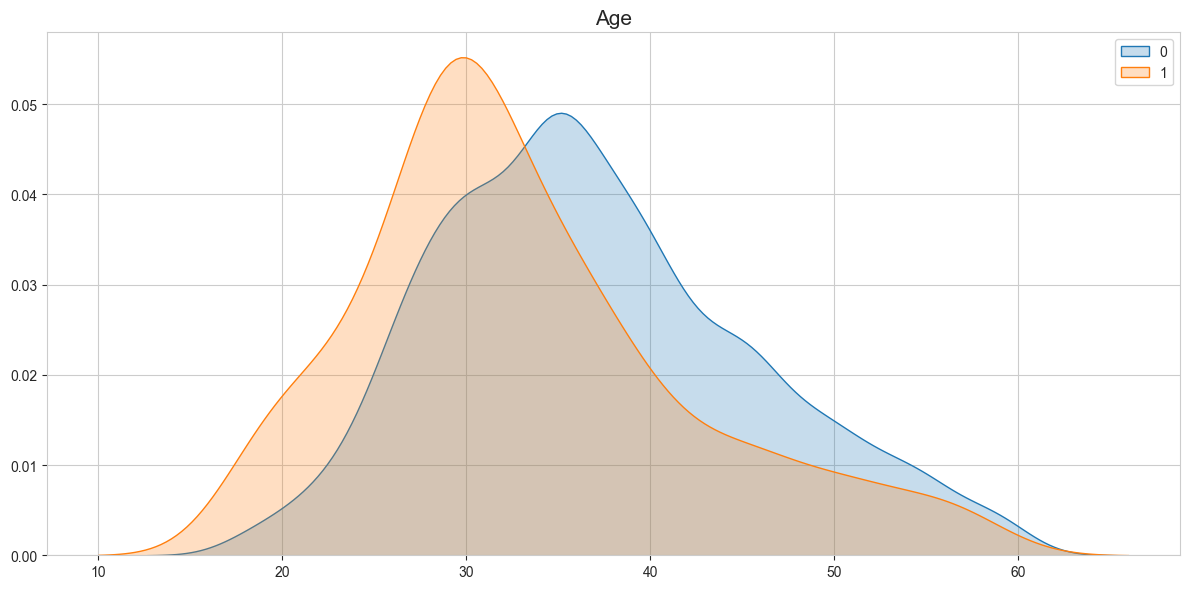

/var/folders/l_/xql371mn41x5cxzwk9st0bfr0000gn/T/ipykernel_30612/888814135.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_train0[feature], shade=True, label="0")
/var/folders/l_/xql371mn41x5cxzwk9st0bfr0000gn/T/ipykernel_30612/888814135.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_train1[feature], shade=True, label="1")


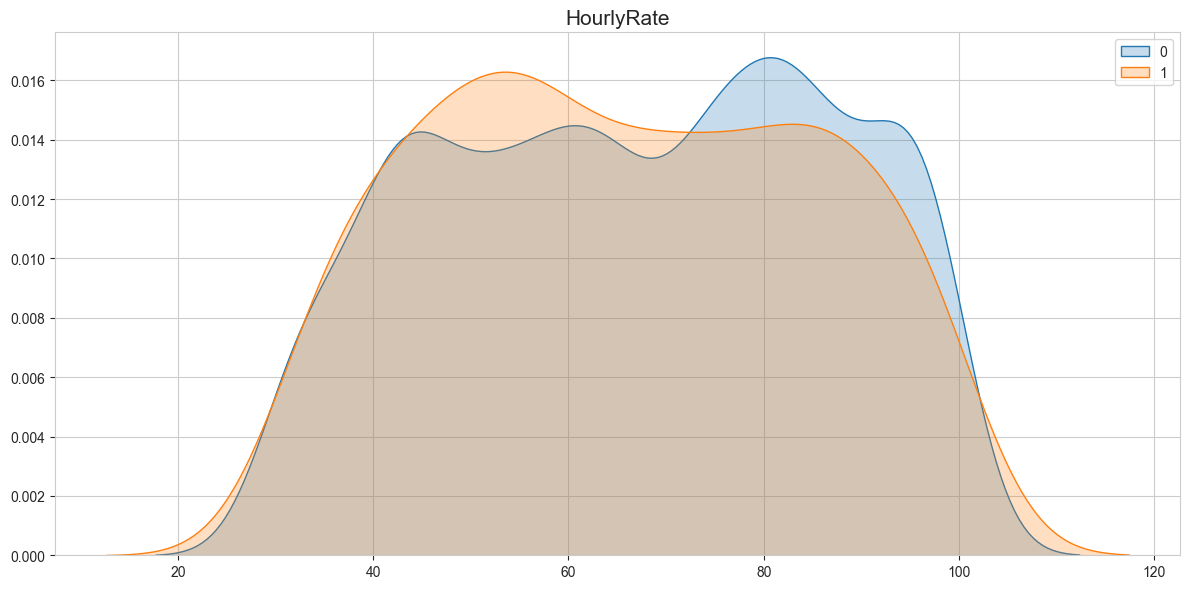

/var/folders/l_/xql371mn41x5cxzwk9st0bfr0000gn/T/ipykernel_30612/888814135.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_train0[feature], shade=True, label="0")
/var/folders/l_/xql371mn41x5cxzwk9st0bfr0000gn/T/ipykernel_30612/888814135.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_train1[feature], shade=True, label="1")


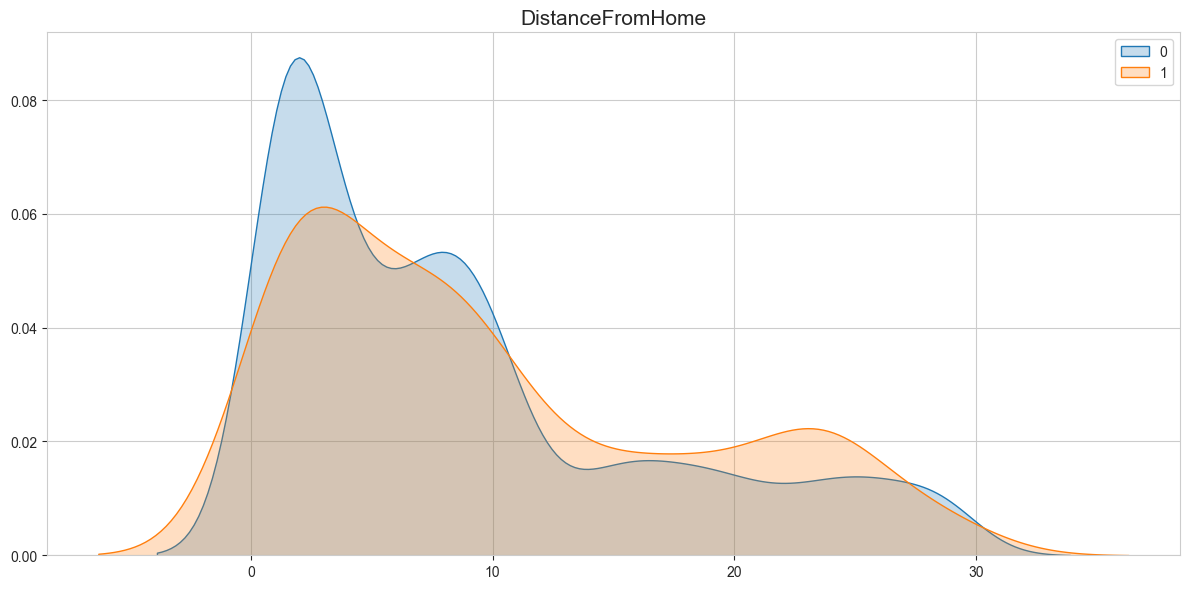

/var/folders/l_/xql371mn41x5cxzwk9st0bfr0000gn/T/ipykernel_30612/888814135.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_train0[feature], shade=True, label="0")
/var/folders/l_/xql371mn41x5cxzwk9st0bfr0000gn/T/ipykernel_30612/888814135.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_train1[feature], shade=True, label="1")


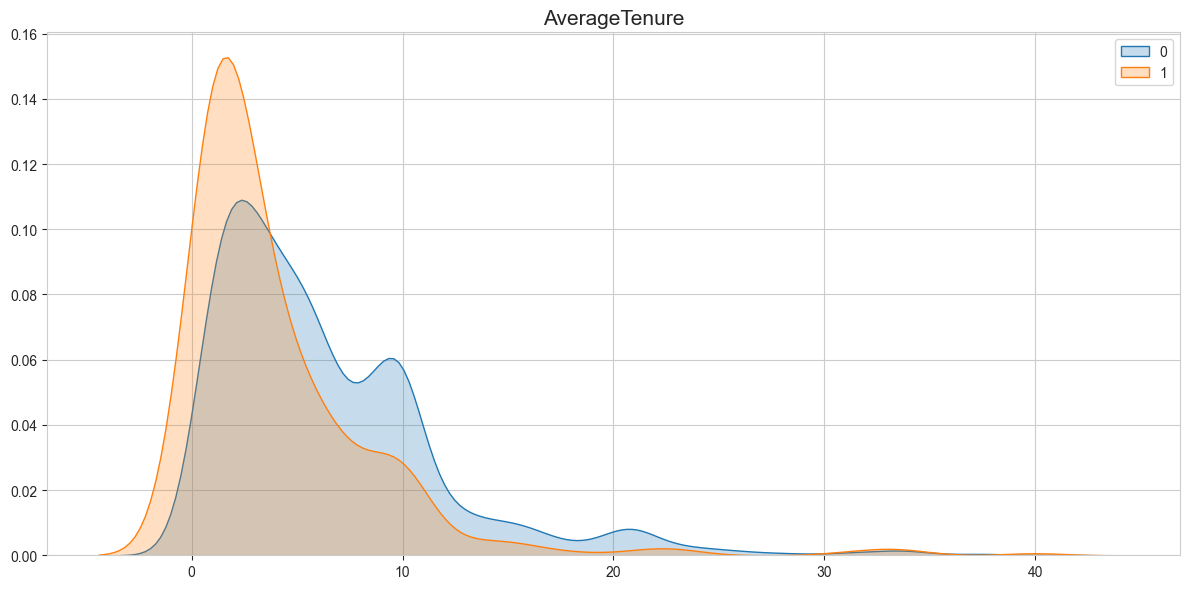

/var/folders/l_/xql371mn41x5cxzwk9st0bfr0000gn/T/ipykernel_30612/888814135.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_train0[feature], shade=True, label="0")
/var/folders/l_/xql371mn41x5cxzwk9st0bfr0000gn/T/ipykernel_30612/888814135.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_train1[feature], shade=True, label="1")


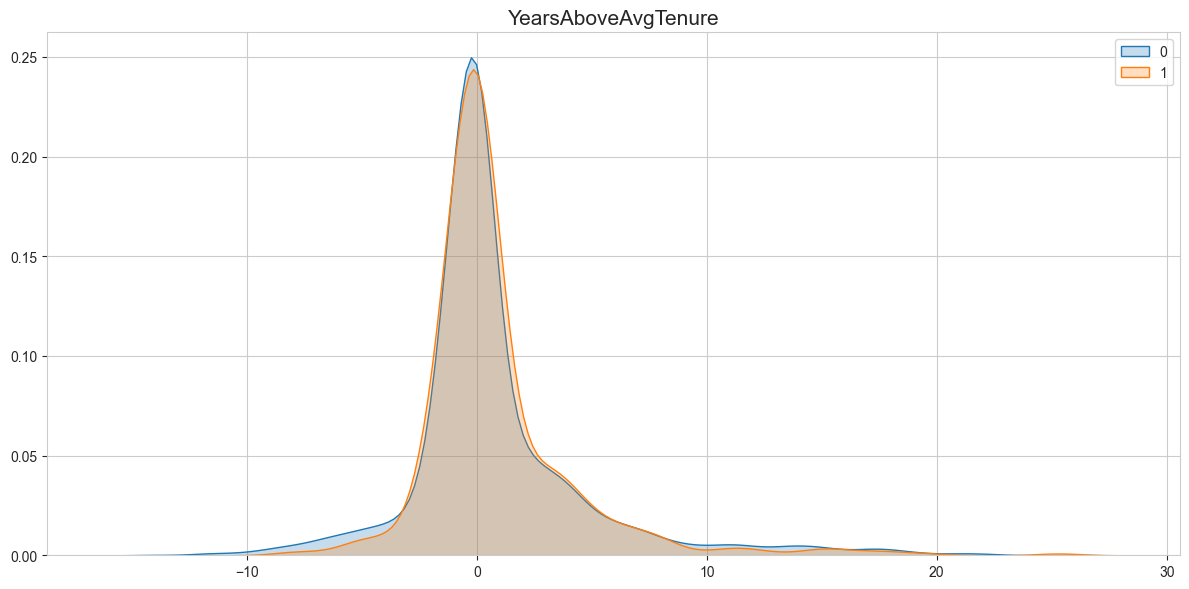

/var/folders/l_/xql371mn41x5cxzwk9st0bfr0000gn/T/ipykernel_30612/888814135.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_train0[feature], shade=True, label="0")
/var/folders/l_/xql371mn41x5cxzwk9st0bfr0000gn/T/ipykernel_30612/888814135.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_train1[feature], shade=True, label="1")


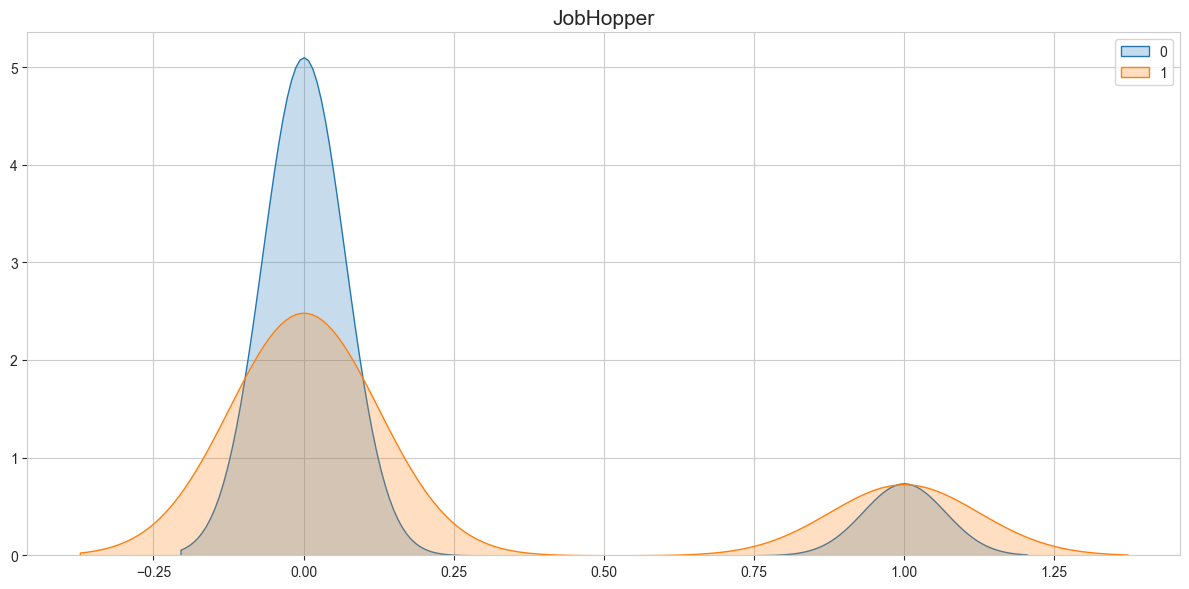

/var/folders/l_/xql371mn41x5cxzwk9st0bfr0000gn/T/ipykernel_30612/888814135.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_train0[feature], shade=True, label="0")
/var/folders/l_/xql371mn41x5cxzwk9st0bfr0000gn/T/ipykernel_30612/888814135.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_train1[feature], shade=True, label="1")


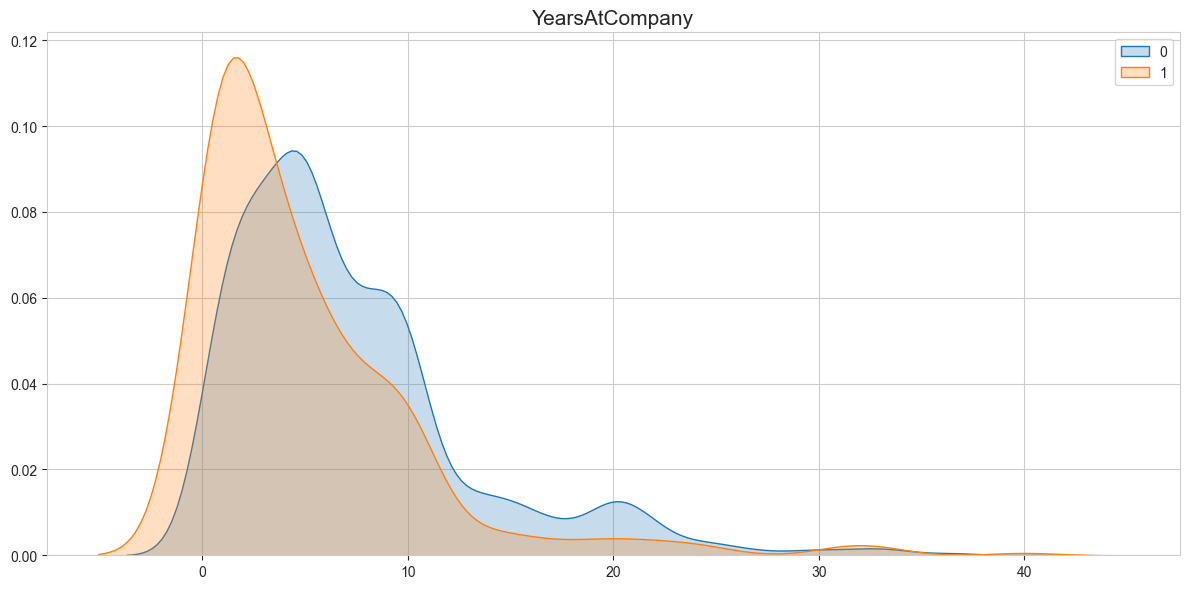

/var/folders/l_/xql371mn41x5cxzwk9st0bfr0000gn/T/ipykernel_30612/888814135.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_train0[feature], shade=True, label="0")
/var/folders/l_/xql371mn41x5cxzwk9st0bfr0000gn/T/ipykernel_30612/888814135.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_train1[feature], shade=True, label="1")


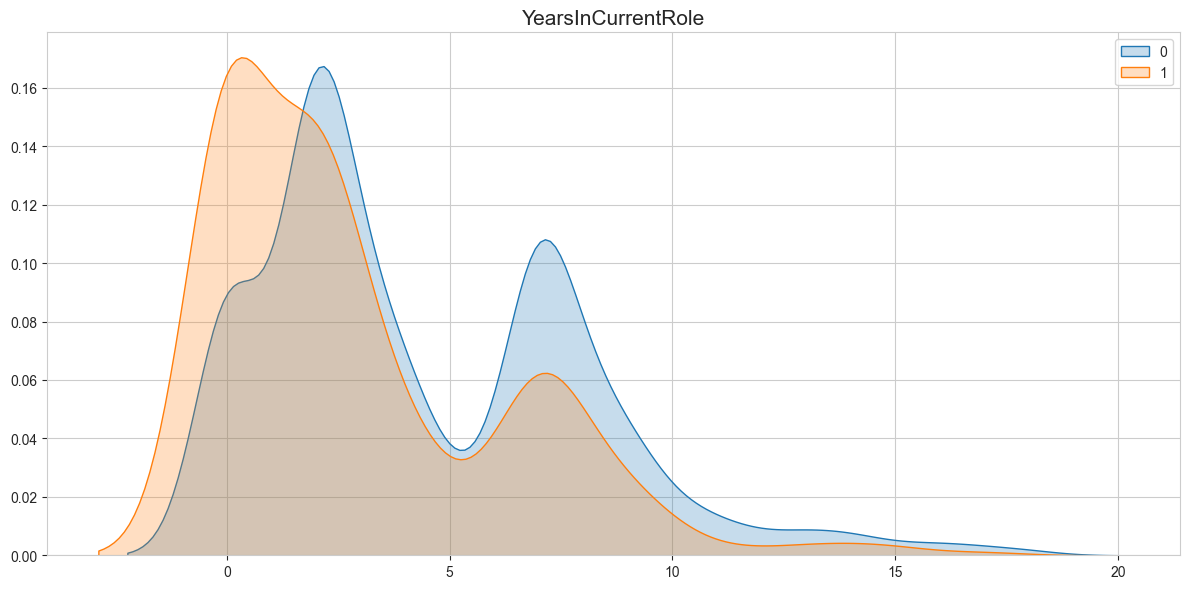

/var/folders/l_/xql371mn41x5cxzwk9st0bfr0000gn/T/ipykernel_30612/888814135.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_train0[feature], shade=True, label="0")
/var/folders/l_/xql371mn41x5cxzwk9st0bfr0000gn/T/ipykernel_30612/888814135.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_train1[feature], shade=True, label="1")


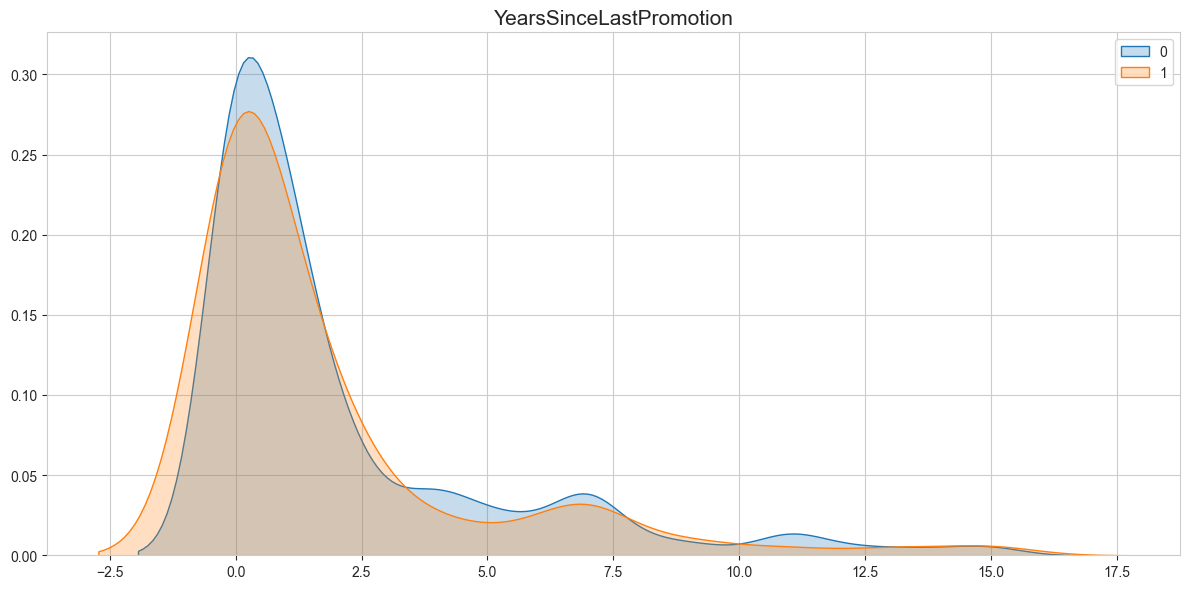

/var/folders/l_/xql371mn41x5cxzwk9st0bfr0000gn/T/ipykernel_30612/888814135.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_train0[feature], shade=True, label="0")
/var/folders/l_/xql371mn41x5cxzwk9st0bfr0000gn/T/ipykernel_30612/888814135.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_train1[feature], shade=True, label="1")


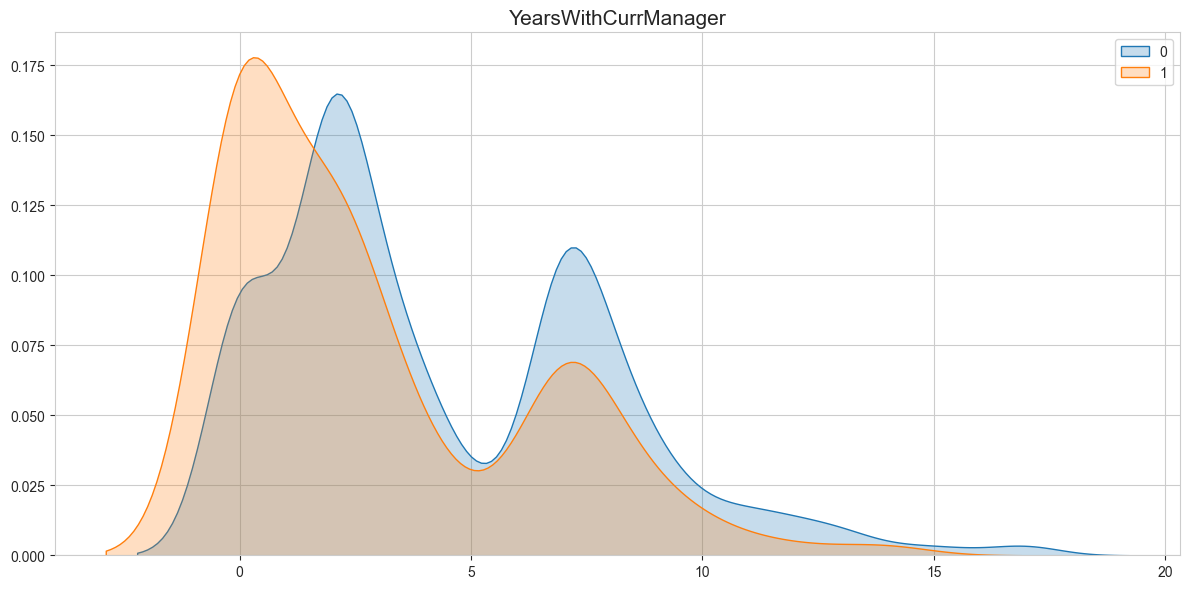

/var/folders/l_/xql371mn41x5cxzwk9st0bfr0000gn/T/ipykernel_30612/888814135.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_train0[feature], shade=True, label="0")
/var/folders/l_/xql371mn41x5cxzwk9st0bfr0000gn/T/ipykernel_30612/888814135.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_train1[feature], shade=True, label="1")


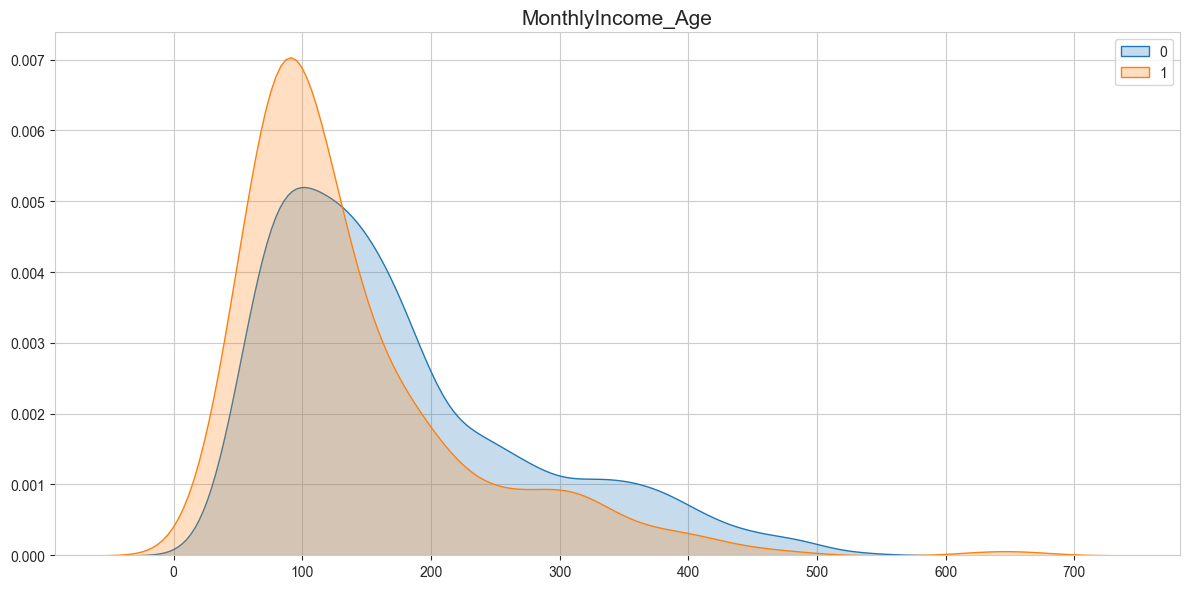

In [8]:
sns.set_style("whitegrid", {"xtick.bottom" : True, "ytick.left" : True})

df_train0 = data_raw[data_raw["Attrition"] == 0]
df_train1 = data_raw[data_raw["Attrition"] == 1]
features = ["Age", "HourlyRate", "DistanceFromHome", "AverageTenure", "YearsAboveAvgTenure", "JobHopper",
            "YearsAtCompany", "YearsInCurrentRole", "YearsSinceLastPromotion", "YearsWithCurrManager",
            "MonthlyIncome_Age"]

for feature in features:
    plt.figure(figsize=(12, 6))
    sns.kdeplot(df_train0[feature], shade=True, label="0")
    sns.kdeplot(df_train1[feature], shade=True, label="1")
    plt.title("{}".format(feature), fontsize=15)
    plt.ylabel("")
    plt.xlabel("")
    plt.tight_layout()
    plt.savefig("distributions_%s.png" % feature, dpi=150)
    plt.legend()
    plt.show()

Теперь видно, какие можно сделать факторы риска.

In [9]:
def add_features(df):
    df["Age_risk"] = (df["Age"] < 34).astype(int)
    df["HourlyRate_risk"] = (df["HourlyRate"] < 60).astype(int)
    df["Distance_risk"] = (df["DistanceFromHome"] >= 20).astype(int)
    df["YearsAtCo_risk"] = (df["YearsAtCompany"] < 4).astype(int)
    return df

In [10]:
X_train = add_features(X_train)
X_test = add_features(X_test)

Снова прогоним бейслайн

In [11]:
cat_features = [col for col in df.columns if 20 >= X_train[col].nunique() > 1]
cont_features = [col for col in df.columns if X_train[col].nunique() > 20]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), cont_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)

base_pipeline = Pipeline([
    ("transform", preprocessor),
    ('random_forest', CatBoostClassifier(verbose=False))
])

cross_validate(X_train, y_train, base_pipeline)

Fold 0 	 auc: 0.9014592418651459
Fold 1 	 auc: 0.8171754444817175
Fold 2 	 auc: 0.8258134854075814
Fold 3 	 auc: 0.9217544448171755
Fold 4 	 auc: 0.7983059376048306
Fold 5 	 auc: 0.8119758470311976
Fold 6 	 auc: 0.8450184501845018
Fold 7 	 auc: 0.8590062644812495
Fold 8 	 auc: 0.8557453016390628
Fold 9 	 auc: 0.8564318201321547
Avg AUC: 0.8492686237644618


In [12]:
X_train

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,YearsWithCurrManager,EmployeeNumber,AverageTenure,MonthlyIncome_Age,JobHopper,YearsAboveAvgTenure,Age_risk,HourlyRate_risk,Distance_risk,YearsAtCo_risk
0,36,Travel_Frequently,599,Research & Development,24,3,Medical,4,Male,42.0,...,8,NaN,10.00,72.111111,0,0.00,0,1,1,0
1,35,Travel_Rarely,921,Sales,8,3,Other,1,Male,46.0,...,3,NaN,4.00,82.828571,0,0.00,0,1,0,0
2,32,Travel_Rarely,718,Sales,26,3,Marketing,3,Male,80.0,...,2,NaN,4.00,144.593750,0,-1.00,1,0,1,1
3,38,Travel_Rarely,1485,Research & Development,2,3,Medical,3,Female,40.0,...,2,NaN,5.00,140.710526,0,1.00,0,1,0,0
4,50,Travel_Rarely,1017,Research & Development,5,4,Medical,2,Female,37.0,...,10,NaN,31.00,380.660000,0,-1.46,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,Travel_Frequently,884,Research & Development,23,2,Medical,3,Male,41.0,...,3,2061.0,4.25,71.416667,0,0.75,0,1,1,0
1466,39,Travel_Rarely,613,Research & Development,6,1,Medical,4,Male,42.0,...,7,2062.0,2.25,256.179487,0,4.75,0,1,0,0
1467,27,Travel_Rarely,155,Research & Development,4,3,Life Sciences,2,Male,87.0,...,3,2064.0,6.00,227.481481,0,0.00,1,0,0,0
1468,49,Travel_Frequently,1023,Sales,2,3,Medical,4,Male,63.0,...,8,2065.0,8.50,110.000000,0,0.50,0,0,0,0


Стало чуть получше, попробуем ансамбли.

In [13]:
xgb_params = {'n_estimators': 150,
              'max_depth': 3,
              'learning_rate': 0.1,
              'min_child_weight': 4,
              'subsample': 0.7,
              'colsample_bytree': 0.3
              }

xgb_pipeline = Pipeline([
    ("transform", preprocessor),
    ('random_forest', XGBClassifier(**xgb_params))
])

cross_validate(X_train, y_train, xgb_pipeline)

xgb_pipeline.fit(X_train, y_train)

Fold 0 	 auc: 0.9102650117410265
Fold 1 	 auc: 0.8248071117074807
Fold 2 	 auc: 0.8264844012076484
Fold 3 	 auc: 0.9186514592418652
Fold 4 	 auc: 0.8136531365313654
Fold 5 	 auc: 0.8226266353572628
Fold 6 	 auc: 0.8403220395840321
Fold 7 	 auc: 0.863125375439801
Fold 8 	 auc: 0.8572899682485197
Fold 9 	 auc: 0.8640693383678023
Avg AUC: 0.8541294477426804


Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'DailyRate',
                                                   'DistanceFromHome',
                                                   'HourlyRate',
                                                   'MonthlyIncome',
                                                   'MonthlyRate',
                                                   'TotalWorkingYears',
                                                   'YearsAtCompany',
                                                   'AverageTenure',
                                                   'MonthlyIncome_Age',
                                                   'YearsAboveAvgTenure']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['BusinessTravel',
                                                   'Department', 'Education...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None, min_child_weight=4,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=150,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, ...))])

In [14]:
catboost_params = {'loss_function': 'CrossEntropy',
                   'learning_rate': 0.76,
                   'l2_leaf_reg': 0.014,
                   'colsample_bylevel': 0.06,
                   'depth': 1,
                   'boosting_type': 'Plain',
                   'bootstrap_type': 'Bernoulli',
                   'min_data_in_leaf': 18,
                   'one_hot_max_size': 14,
                   'subsample': 0.99,
                   'verbose': False,
                   }

cat_pipeline = Pipeline([
    ("transform", preprocessor),
    ('random_forest', CatBoostClassifier(**catboost_params))
])

cross_validate(X_train, y_train, cat_pipeline)

cat_pipeline.fit(X_train, y_train)

Fold 0 	 auc: 0.8808285810130829
Fold 1 	 auc: 0.782120093928212
Fold 2 	 auc: 0.8040087219054008
Fold 3 	 auc: 0.9142905065414291
Fold 4 	 auc: 0.7849714860784972
Fold 5 	 auc: 0.812311304931231
Fold 6 	 auc: 0.8453539080845354
Fold 7 	 auc: 0.8583197459881574
Fold 8 	 auc: 0.8696473011241739
Fold 9 	 auc: 0.8418433021539518
Avg AUC: 0.8393694951748671


Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'DailyRate',
                                                   'DistanceFromHome',
                                                   'HourlyRate',
                                                   'MonthlyIncome',
                                                   'MonthlyRate',
                                                   'TotalWorkingYears',
                                                   'YearsAtCompany',
                                                   'AverageTenure',
                                                   'MonthlyIncome_Age',
                                                   'YearsAboveAvgTenure']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['BusinessTravel',
                                                   'Department', 'Education...
                                                   'PercentSalaryHike',
                                                   'PerformanceRating',
                                                   'RelationshipSatisfaction',
                                                   'StockOptionLevel',
                                                   'TrainingTimesLastYear',
                                                   'WorkLifeBalance',
                                                   'YearsInCurrentRole',
                                                   'YearsSinceLastPromotion',
                                                   'YearsWithCurrManager',
                                                   'JobHopper', 'Age_risk',
                                                   'HourlyRate_risk',
                                                   'Distance_risk',
                                                   'YearsAtCo_risk'])])),
                ('random_forest',
                 <catboost.core.CatBoostClassifier object at 0x32be84550>)])

In [15]:
lgbm_params = {'n_estimators': 407,
               'num_rounds': 274,
               'learning_rate': 0.1,
               'num_leaves': 195,
               'max_depth': 9,
               'min_data_in_leaf': 46,
               'lambda_l1': 0.01,
               'lambda_l2': 0.6,
               'min_gain_to_split': 1.42,
               'bagging_fraction': 0.45,
               'feature_fraction': 0.3,
               'verbose': 0}

lgbm_pipeline = Pipeline([
    ("transform", preprocessor),
    ('random_forest', LGBMClassifier(**lgbm_params))
])

cross_validate(X_train, y_train, lgbm_pipeline)

lgbm_pipeline.fit(X_train, y_train)

/Users/ddresh/IdeaProjects/hw1pdrissber/venv/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.6, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_fraction is set=0.45, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45
[LightGBM] [Warning] num_iterations is set=274, num_rounds=274 will be ignored. Current value: num_iterations=274
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_gain_to_split is set=1.42, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.42
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.6, reg_lambda=0.0 will be ignored. Curren

/Users/ddresh/IdeaProjects/hw1pdrissber/venv/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/ddresh/IdeaProjects/hw1pdrissber/venv/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/ddresh/IdeaProjects/hw1pdrissber/venv/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/ddresh/IdeaProjects/hw1pdrissber/venv/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/ddresh/IdeaProjects/hw1pdrissber/venv/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/ddresh/IdeaProjects/hw1pdrissber/venv/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/ddresh/IdeaProjects/hw1pdrissber/venv/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/ddresh/IdeaProjects/hw1pdrissber/venv/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/ddresh/IdeaProjects/hw1pdrissber/venv/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/ddresh/IdeaProjects/hw1pdrissber/venv/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'DailyRate',
                                                   'DistanceFromHome',
                                                   'HourlyRate',
                                                   'MonthlyIncome',
                                                   'MonthlyRate',
                                                   'TotalWorkingYears',
                                                   'YearsAtCompany',
                                                   'AverageTenure',
                                                   'MonthlyIncome_Age',
                                                   'YearsAboveAvgTenure']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['BusinessTravel',
                                                   'Department', 'Education...
                                                   'YearsInCurrentRole',
                                                   'YearsSinceLastPromotion',
                                                   'YearsWithCurrManager',
                                                   'JobHopper', 'Age_risk',
                                                   'HourlyRate_risk',
                                                   'Distance_risk',
                                                   'YearsAtCo_risk'])])),
                ('random_forest',
                 LGBMClassifier(bagging_fraction=0.45, feature_fraction=0.3,
                                lambda_l1=0.01, lambda_l2=0.6, max_depth=9,
                                min_data_in_leaf=46, min_gain_to_split=1.42,
                                n_estimators=407, num_leaves=195,
                                num_rounds=274, verbose=0))])

In [16]:
xgb_preds = xgb_pipeline.predict_proba(X_test)[:, 1]
lgbm_preds = lgbm_pipeline.predict_proba(X_test)[:, 1]
cat_preds = cat_pipeline.predict_proba(X_test)[:, 1]

[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] min_gain_to_split is set=1.42, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.42
[LightGBM] [Warning] bagging_fraction is set=0.45, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45
[LightGBM] [Warning] lambda_l2 is set=0.6, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46


In [76]:
final_preds = np.column_stack([xgb_preds, xgb_preds, xgb_preds, xgb_preds, xgb_preds, cat_preds]).mean(axis=1)

In [77]:
submission = pd.DataFrame({"id": X_test_raw["id"], "Attrition": final_preds})
submission.head()

,id,Attrition
0,1677,0.154538
1,1678,0.124984
2,1679,0.074167
3,1680,0.033935
4,1681,0.637194


In [78]:
submission.to_csv("result.csv", index=False)